In [2]:
# Never do this, but warnings are annoying so I'm blocking them
import warnings
warnings.filterwarnings("ignore")

import  keras.layers  as  klayers 
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Input, Embedding, GlobalAveragePooling1D, Concatenate, Activation, Lambda, BatchNormalization, Convolution1D, Dropout
from keras.preprocessing.text import Tokenizer
import numpy as np
import nltk
from sklearn.metrics import cohen_kappa_score
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import initializers
from scipy import stats

from skll.metrics import kappa
from bhkappa import mean_quadratic_weighted_kappa

Using TensorFlow backend.


In [3]:
class Neural_Tensor_layer(Layer):
	def __init__(self,output_dim,input_dim=None, **kwargs):
		self.output_dim=output_dim
		self.input_dim=input_dim
		if self.input_dim:
			kwargs['input_shape']=(self.input_dim,)
		super(Neural_Tensor_layer,self).__init__(**kwargs)

	def call(self,inputs,mask=None):
		e1=inputs[0]
		e2=inputs[1]
		batch_size=K.shape(e1)[0]
		k=self.output_dim
		

		feed_forward=K.dot(K.concatenate([e1,e2]),self.V)

		bilinear_tensor_products = [ K.sum((e2 * K.dot(e1, self.W[0])) + self.b, axis=1) ]

		for i in range(k)[1:]:	
			btp=K.sum((e2*K.dot(e1,self.W[i]))+self.b,axis=1)
			bilinear_tensor_products.append(btp)

		result=K.tanh(K.reshape(K.concatenate(bilinear_tensor_products,axis=0),(batch_size,k))+feed_forward)

		return result
    
	def build(self,input_shape):
		mean=0.0
		std=1.0
		k=self.output_dim
		d=self.input_dim
		##truncnorm generate continuous random numbers in given range
		W_val=stats.truncnorm.rvs(-2 * std, 2 * std, loc=mean, scale=std, size=(k,d,d))
		V_val=stats.truncnorm.rvs(-2 * std, 2 * std, loc=mean, scale=std, size=(2*d,k))
		self.W=K.variable(W_val)
		self.V=K.variable(V_val)
		self.b=K.zeros((self.input_dim,))
		self.trainable_weights=[self.W,self.V,self.b]    

	def compute_output_shape(self, input_shape):
		batch_size=input_shape[0][0]
		return(batch_size,self.output_dim)

In [4]:
class Temporal_Mean_Pooling(Layer): # conversion from (samples,timesteps,features) to (samples,features)
	def __init__(self, **kwargs):
		super(Temporal_Mean_Pooling,self).__init__(**kwargs)
		# masked values in x (number_of_samples,time)
		self.supports_masking=True
		# Specifies number of dimensions to each layer
		self.input_spec=InputSpec(ndim=3)
        
	def call(self,x,mask=None):
		if mask is None:
			mask=K.mean(K.ones_like(x),axis=-1)

		mask=K.cast(mask,K.floatx())
				#dimension size single vec/number of samples
		return K.sum(x,axis=-2)/K.sum(mask,axis=-1,keepdims=True)        

	def compute_mask(self,input,mask):
		return None
    
    
	def compute_output_shape(self,input_shape):
		return (input_shape[0],input_shape[2])

In [6]:
EMBEDDING_DIM=300
MAX_NB_WORDS=4000

MAX_SEQUENCE_LENGTH=500
VALIDATION_SPLIT=0.20
DELTA=20

texts=[]
labels=[]
sentences=[]

originals = []

fp1=open("glove.6B.300d.txt","r", encoding="utf8")
glove_emb={}
for line in fp1:
	temp=line.split(" ")
	glove_emb[temp[0]]=np.asarray([float(i) for i in temp[1:]])

print("Embedding done")

Embedding done


In [7]:
essay_type = '5'

fp=open("data/training_set.tsv",'r', encoding="ascii", errors="ignore")
fp.readline()
for line in fp:
    temp=line.split("\t")
    if(temp[1]==essay_type): ## why only 4 ?? - evals in prompt specific fashion
        originals.append(float(temp[6]))
fp.close()

print("range min - ", min(originals) , " ; range max - ", max(originals))

range_min = min(originals)
range_max = max(originals)

fp=open("data/training_set.tsv",'r', encoding="ascii", errors="ignore")
fp.readline()
sentences=[]
for line in fp:
    temp=line.split("\t")
    if(temp[1]==essay_type): ## why only 4 ?? - evals in prompt specific fashion
        texts.append(temp[2])
        labels.append((float(temp[6])-range_min)/(range_max-range_min)) ## why ??  - normalize to range [0-1]
        line=temp[2].strip()
        sentences.append(nltk.tokenize.word_tokenize(line))

fp.close()

range min -  0.0  ; range max -  4.0


In [8]:
print("text labels appended %s" %len(texts))

labels=np.asarray(labels)

text labels appended 1805


In [9]:
for i in sentences:
	temp1=np.zeros((1, EMBEDDING_DIM))
	for w in i:
		if(w in glove_emb):
			temp1+=glove_emb[w]
	temp1/=len(i)

In [10]:
tokenizer=Tokenizer() #num_words=MAX_NB_WORDS) #limits vocabulory size
tokenizer.fit_on_texts(texts)
sequences=tokenizer.texts_to_sequences(texts) #returns list of sequences
word_index=tokenizer.word_index #dictionary mapping
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


print('Shape of data tensor:', data.shape)

Found 5002 unique tokens.
Shape of data tensor: (1805, 500)


In [11]:
indices=np.arange(data.shape[0])
np.random.shuffle(indices)
data=data[indices]
labels=labels[indices]
validation_size=int(VALIDATION_SPLIT*data.shape[0])

In [12]:
x_train=data[:-validation_size]
y_train=labels[:-validation_size]
x_val=data[-validation_size:]
y_val=labels[-validation_size:]

In [13]:
embedding_matrix = np.zeros((len(word_index), EMBEDDING_DIM))

In [14]:
for word,i in word_index.items():
	if(i>=len(word_index)):
		continue
	if word in glove_emb:
			embedding_matrix[i]=glove_emb[word]
vocab_size=len(word_index)

In [15]:
embedding_layer=Embedding(vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],
							input_length=MAX_SEQUENCE_LENGTH,
							mask_zero=True,
							trainable=False)
side_embedding_layer=Embedding(vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],
							input_length=MAX_SEQUENCE_LENGTH,
							mask_zero=False,
							trainable=False)

In [16]:
def SKIPFLOW(lstm_dim=50, lr=1e-4, lr_decay=1e-6, k=5, eta=3, delta=50, activation="relu", maxlen=MAX_SEQUENCE_LENGTH, seed=None):
	e = Input(name='essay',shape=(maxlen,))
	trad_feats=Input(shape=(7,))
	embed = embedding_layer(e)
	lstm_layer=LSTM(lstm_dim,return_sequences=True) 
	hidden_states=lstm_layer(embed)
	htm=Temporal_Mean_Pooling()(hidden_states)    
	side_embed = side_embedding_layer(e)
	side_hidden_states=lstm_layer(side_embed)   
	tensor_layer=Neural_Tensor_layer(output_dim=k,input_dim=lstm_dim)
	pairs = [((eta + i * delta) % maxlen, (eta + i * delta + delta) % maxlen) for i in range(maxlen // delta)]
	hidden_pairs = [ (Lambda(lambda t: t[:, p[0], :])(side_hidden_states), Lambda(lambda t: t[:, p[1], :])(side_hidden_states)) for p in pairs]
	sigmoid = Dense(1, activation="sigmoid", kernel_initializer=initializers.glorot_normal(seed=seed))
	coherence = [sigmoid(tensor_layer([hp[0], hp[1]])) for hp in hidden_pairs]
	co_tm=Concatenate()(coherence[:]+[htm])
	dense = Dense(256, activation=activation,kernel_initializer=initializers.glorot_normal(seed=seed))(co_tm)
	dense = Dense(128, activation=activation,kernel_initializer=initializers.glorot_normal(seed=seed))(dense)
	dense = Dense(64, activation=activation,kernel_initializer=initializers.glorot_normal(seed=seed))(dense)
	out = Dense(1, activation="sigmoid")(dense)
	model = Model(inputs=[e], outputs=[out]) # inputs=[e,trad_feats]
	adam = Adam(lr=lr, decay=lr_decay)
	model.compile(loss="mean_squared_error", optimizer=adam, metrics=["MSE"])
	return model

In [17]:
earlystopping = EarlyStopping(monitor="val_MSE", patience=5)
sf_1 = SKIPFLOW(lstm_dim=50, lr=2e-4, lr_decay=2e-6, k=4, eta=13, delta=50, activation="relu", seed=None)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
tracking <tf.Variable 'neural__tensor_layer_1/Variable:0' shape=(4, 50, 50) dtype=float32> W
tracking <tf.Variable 'neural__tensor_layer_1/Variable_1:0' shape=(100, 4) dtype=float32> V
tracking <tf.Variable 'neural__tensor_layer_1/Variable_2:0' shape=(50,) dtype=float32> b


In [16]:
epochs = 100    # 1000 has also been suggested
hist = sf_1.fit([x_train], y_train, batch_size=32, epochs=epochs,   # Used to be 1024
                validation_data=([x_val], y_val), callbacks=[earlystopping])


Train on 1444 samples, validate on 361 samples
Epoch 1/100
1444/1444 [==============================] - 45s 31ms/step - loss: 0.0530 - MSE: 0.0530 - val_loss: 0.0505 - val_MSE: 0.0505
Epoch 2/100
1444/1444 [==============================] - 43s 30ms/step - loss: 0.0336 - MSE: 0.0336 - val_loss: 0.0247 - val_MSE: 0.0247
Epoch 3/100
1444/1444 [==============================] - 43s 29ms/step - loss: 0.0221 - MSE: 0.0221 - val_loss: 0.0201 - val_MSE: 0.0201
Epoch 4/100
1444/1444 [==============================] - 44s 30ms/step - loss: 0.0201 - MSE: 0.0201 - val_loss: 0.0191 - val_MSE: 0.0191
Epoch 5/100
1444/1444 [==============================] - 43s 30ms/step - loss: 0.0193 - MSE: 0.0193 - val_loss: 0.0185 - val_MSE: 0.0185
Epoch 6/100
1444/1444 [==============================] - 45s 31ms/step - loss: 0.0182 - MSE: 0.0182 - val_loss: 0.0204 - val_MSE: 0.0204
Epoch 7/100
1444/1444 [==============================] - 48s 33ms/step - loss: 0.0177 - MSE: 0.0177 - val_loss: 0.0181 - val_MSE: 

In [17]:
y_pred=sf_1.predict([x_val])
y_val_fin = [int(round(a*(range_max-range_min)+range_min)) for a in y_val]
y_pred_fin =[int(round(a*(range_max-range_min)+range_min)) for a in y_pred.reshape(361).tolist()] #Change this to match output shape
print(cohen_kappa_score(y_val_fin,y_pred_fin,weights="quadratic"))

0.8175947198471535


In [75]:
sf_1.save('models/5_model.h5')
sf_1.save_weights('models/5_weights.h5')

In [48]:
y_pred*(range_max-range_min)+range_min

array([[3.2809587 ],
       [2.9796457 ],
       [1.967578  ],
       [3.6454659 ],
       [1.3921044 ],
       [3.231636  ],
       [2.7819629 ],
       [2.7494287 ],
       [1.9229802 ],
       [2.3569622 ],
       [3.7367249 ],
       [3.051389  ],
       [3.6930866 ],
       [2.5271583 ],
       [1.542272  ],
       [2.8635821 ],
       [1.4765416 ],
       [2.4264169 ],
       [3.4015884 ],
       [2.6793268 ],
       [2.9679804 ],
       [1.8038375 ],
       [3.6541696 ],
       [0.96453047],
       [1.4069722 ],
       [1.6748512 ],
       [2.834257  ],
       [3.03832   ],
       [1.5418419 ],
       [2.2322204 ],
       [1.9243249 ],
       [2.4652753 ],
       [3.2020397 ],
       [3.2474005 ],
       [1.871345  ],
       [3.2284288 ],
       [2.1611218 ],
       [3.227532  ],
       [1.9946692 ],
       [3.02138   ],
       [2.8512318 ],
       [1.9411013 ],
       [1.0613296 ],
       [2.8964298 ],
       [3.0888174 ],
       [1.1007787 ],
       [3.2301497 ],
       [0.775

In [28]:
from keras.utils import plot_model
plot_model(hist)

AttributeError: module 'os' has no attribute 'errno'

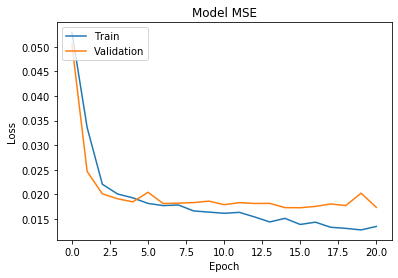

In [26]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(hist.history['MSE'])
plt.plot(hist.history['val_MSE'])
plt.title('Model MSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()